<a href="https://colab.research.google.com/github/mzffreyvazov/ai-experiments/blob/main/fine-tuning/ielts_writing_evaluator_gemini_2_0_flash_lite_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title 1. Install and Import Libraries
!pip uninstall google-cloud-aiplatform -y -q
!pip install --upgrade google-cloud-aiplatform datasets pyarrow -q

import os
import json
from google.colab import auth

import google.cloud.aiplatform
print(f"Vertex AI SDK version: {google.cloud.aiplatform.__version__}")

import vertexai
# from vertexai.language_models import TextGenerationModel # Keep this for loading the tuned model later
from vertexai.generative_models import GenerativeModel # For interacting with Gemini models directly
from vertexai import tuning # Main tuning module

# Attempt to import the specific SFT training function
try:
    from vertexai.tuning import sft
    print("Successfully imported vertexai.tuning.sft")
except ImportError as e:
    print(f"Could not import vertexai.tuning.sft: {e}")
    print("This might indicate an unexpected SDK structure or a very recent change.")
    print("Falling back to trying a direct PipelineJob approach if sft module is not found.")
    sft = None # Set to None if import fails

from datasets import load_dataset
import pandas as pd
import time # For polling job status

Vertex AI SDK version: 1.94.0
Successfully imported vertexai.tuning.sft


In [ ]:
# @title 2. Authenticate and Configure Google Cloud
# Authenticate user
auth.authenticate_user()

# @markdown **Enter your Google Cloud Project ID, Region, and GCS Bucket details:**
PROJECT_ID = "gen-lang-client-0691987424"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"} Choose a region that supports Gemini tuning
BUCKET_NAME = "ielts_bucket_fine_tuning"  # @param {type:"string"} Do NOT include gs:// prefix

# Validate inputs
if not PROJECT_ID or PROJECT_ID == "your-gcp-project-id":
    raise ValueError("Please set your Google Cloud Project ID.")
if not BUCKET_NAME or BUCKET_NAME == "your-gcs-bucket-name":
    raise ValueError("Please set your Google Cloud Storage Bucket name.")

GCS_BUCKET_URI = f"gs://{BUCKET_NAME}"

# Initialize Vertex AI
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=GCS_BUCKET_URI)

print(f"Vertex AI initialized for project: {PROJECT_ID} in region: {REGION}")
print(f"Using GCS Bucket: {GCS_BUCKET_URI}")

# Create GCS bucket if it doesn't exist (optional, good practice)
from google.cloud import storage
storage_client = storage.Client(project=PROJECT_ID)
try:
    bucket = storage_client.get_bucket(BUCKET_NAME)
    print(f"Bucket {BUCKET_NAME} already exists.")
except storage.exceptions.NotFound:
    bucket = storage_client.create_bucket(BUCKET_NAME, location=REGION)
    print(f"Bucket {BUCKET_NAME} created in {REGION}.")

Vertex AI initialized for project: gen-lang-client-0691987424 in region: us-central1
Using GCS Bucket: gs://ielts_bucket_fine_tuning
Bucket ielts_bucket_fine_tuning already exists.


In [ ]:
# @title 3. Load and Prepare the Dataset (Revised for "contents" -> "parts" structure)

# Load dataset from Hugging Face
hf_dataset_name = "chillies/IELTS-writing-task-2-evaluation"
dataset = load_dataset(hf_dataset_name)

print("Dataset loaded:")
print(dataset)

raw_train_df = dataset['train'].to_pandas()
print(f"\nNumber of examples in raw dataset: {len(raw_train_df)}")
print("\nFirst 2 examples of raw data:")
print(raw_train_df.head(2))

# --- Data Formatting for Supervised Fine-Tuning ---
# Trying the "contents": [ {"role": ..., "parts": [{"text": ...}]} ] structure

def format_example_for_sft(row):
    prompt_text = str(row['prompt']).strip()
    essay_text = str(row['essay']).strip()
    user_input_text = f"Task: Evaluate the following IELTS Writing Task 2 essay based on the given prompt.\n\nPrompt: {prompt_text}\n\nEssay: {essay_text}"

    model_output_text = str(row['evaluation']).strip()

    return {
        "contents": [ # Top-level "contents" field
            {
                "role": "user",
                "parts": [{"text": user_input_text}] # Each message has "parts" which is an array of part objects
            },
            {
                "role": "model",
                "parts": [{"text": model_output_text}]
            }
        ]
    }

formatted_data = [format_example_for_sft(row) for index, row in raw_train_df.iterrows()]

print("\nExample of NEW formatted data (with 'contents' -> 'parts'):")
if formatted_data:
    print(json.dumps(formatted_data[0], indent=2))
else:
    print("No data formatted.")

# --- Split into Training and Validation ---
import random
random.seed(42)
random.shuffle(formatted_data)

split_ratio = 0.9
split_index = int(len(formatted_data) * split_ratio)
train_data = formatted_data[:split_index]
validation_data = formatted_data[split_index:]

print(f"\nNumber of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(validation_data)}")

# --- Convert to JSONL strings and save locally ---
def save_to_jsonl(data, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')
    print(f"Saved {len(data)} examples to {filename}")

TRAIN_JSONL_FILE = "ielts_train_sft.jsonl"
VALID_JSONL_FILE = "ielts_validation_sft.jsonl"

save_to_jsonl(train_data, TRAIN_JSONL_FILE)
save_to_jsonl(validation_data, VALID_JSONL_FILE)

Dataset loaded:
DatasetDict({
    train: Dataset({
        features: ['prompt', 'essay', 'evaluation', 'band'],
        num_rows: 9833
    })
    test: Dataset({
        features: ['prompt', 'essay', 'evaluation', 'band'],
        num_rows: 491
    })
})

Number of examples in raw dataset: 9833

First 2 examples of raw data:
                                              prompt  \
0  Interviews form the basic criteria for most la...   
1  Interviews form the basic selecting criteria f...   

                                               essay  \
0  It is believed by some experts that the tradit...   
1  Nowadays numerous huge firms allocate an inter...   

                                          evaluation  \
0  **Task Achievement: [7]**\nThe essay effective...   
1  **Task Achievement:** 5.0\n- The candidate has...   

                                      band  
0  7.5\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r  
1  5.0\n\n\n\n\n\r\r\r\r\r\r\r\r\r\r\r\r\r  

Example of NEW formatted data 

In [ ]:
# @title 4. Upload Formatted Data to Google Cloud Storage

from google.cloud import storage

def upload_to_gcs(local_filepath, gcs_bucket_name, gcs_blob_name):
    """Uploads a file to the bucket."""
    storage_client = storage.Client(project=PROJECT_ID) # PROJECT_ID should be in global scope from Cell 2
    bucket = storage_client.bucket(gcs_bucket_name)
    blob = bucket.blob(gcs_blob_name)
    blob.upload_from_filename(local_filepath)
    gcs_uri = f"gs://{gcs_bucket_name}/{gcs_blob_name}"
    print(f"File {local_filepath} uploaded to {gcs_uri}")
    return gcs_uri

# Define GCS paths for your data
# These are the local filenames from Cell 3
# TRAIN_JSONL_FILE = "ielts_train_sft.jsonl"
# VALID_JSONL_FILE = "ielts_validation_sft.jsonl"

GCS_TRAIN_DATA_PATH = f"ielts_finetuning_data/{TRAIN_JSONL_FILE}" # TRAIN_JSONL_FILE is from Cell 3
GCS_VALID_DATA_PATH = f"ielts_finetuning_data/{VALID_JSONL_FILE}" # VALID_JSONL_FILE is from Cell 3

# Upload
train_data_gcs_uri = upload_to_gcs(TRAIN_JSONL_FILE, BUCKET_NAME, GCS_TRAIN_DATA_PATH) # BUCKET_NAME is from Cell 2
validation_data_gcs_uri = upload_to_gcs(VALID_JSONL_FILE, BUCKET_NAME, GCS_VALID_DATA_PATH)

print("\nTraining data GCS URI:", train_data_gcs_uri)
print("Validation data GCS URI:", validation_data_gcs_uri)

File ielts_train_sft.jsonl uploaded to gs://ielts_bucket_fine_tuning/ielts_finetuning_data/ielts_train_sft.jsonl
File ielts_validation_sft.jsonl uploaded to gs://ielts_bucket_fine_tuning/ielts_finetuning_data/ielts_validation_sft.jsonl

Training data GCS URI: gs://ielts_bucket_fine_tuning/ielts_finetuning_data/ielts_train_sft.jsonl
Validation data GCS URI: gs://ielts_bucket_fine_tuning/ielts_finetuning_data/ielts_validation_sft.jsonl


In [ ]:
# @title 5. Define and Run the Fine-Tuning Job
from google.cloud import aiplatform
# --- Model and Job Configuration ---
BASE_MODEL_ID = "gemini-2.0-flash-lite-001" # The correct ID you found

# Give your tuned model a display name
TUNED_MODEL_DISPLAY_NAME = "ielts-writing-evaluator-gemini-2.0-flash-lite-001" # Updated to match

# Training steps/epochs (Optional: if you want to override defaults and know the exact parameter name for sft.train)
# EPOCHS = 3 # Example: If sft.train takes an 'epochs' parameter
# TRAIN_STEPS = 300 # Example: If sft.train takes a 'train_steps' or 'total_steps' parameter

print(f"Starting fine-tuning job for base model: {BASE_MODEL_ID}")
print(f"Tuned model will be named: {TUNED_MODEL_DISPLAY_NAME}")
print(f"Training data: {train_data_gcs_uri}") # From Cell 4
print(f"Validation data: {validation_data_gcs_uri}") # From Cell 4

sft_tuning_job_object = None # Initialize variable to store the job object from sft.train()

# Ensure the 'sft' module we tried to import in Cell 1 is available
if 'sft' in globals() and sft is not None:
    try:
        print("\nUsing vertexai.tuning.sft.train()...")
        sft_tuning_job_object = sft.train(
            source_model=BASE_MODEL_ID,
            train_dataset=train_data_gcs_uri,
            validation_dataset=validation_data_gcs_uri, # Parameter name for validation data
            tuned_model_display_name=TUNED_MODEL_DISPLAY_NAME,
            # --- Optional Hyperparameters ---
            # If using epochs and 'epochs' is a valid parameter for sft.train() for this model:
            # epochs=EPOCHS,
            # If using specific number of steps and 'train_steps' or 'total_steps' is valid:
            # train_steps=TRAIN_STEPS,
            # Other potential parameters: learning_rate_multiplier, adapter_size etc.
            # Relying on SDK defaults if not specified.
        )

        print("\nSupervised fine-tuning job submitted via sft.train(). Initial job details:")
        # The object returned by sft.train() is the job itself.
        # For SDK 1.94.0, it seems to be a SupervisedTuningJob object.
        print(sft_tuning_job_object)
        if hasattr(sft_tuning_job_object, 'resource_name'):
             print(f"Job Resource Name: {sft_tuning_job_object.resource_name}")
             print(f"View Tuning Job in Console: https://console.cloud.google.com/vertex-ai/generative/language/locations/{REGION}/tuning/tuningJob/{sft_tuning_job_object.resource_name.split('/')[-1]}?project={PROJECT_ID}")
        else:
            print("Could not retrieve job resource name directly from the returned job object initially.")


        # Polling for job completion
        # The job resource name is needed for the PipelineJob.get() method.
        if hasattr(sft_tuning_job_object, 'resource_name') and sft_tuning_job_object.resource_name:
            print(f"\nPolling job status for TuningJob: {sft_tuning_job_object.resource_name} (this may take a while)...")

            while not sft_tuning_job_object.has_ended: # SupervisedTuningJob has a 'has_ended' property
                time.sleep(60) # Wait for 60 seconds
                sft_tuning_job_object.refresh() # Refresh the SupervisedTuningJob object's state
                # Log timestamp and current state
                current_display_name = getattr(sft_tuning_job_object, 'display_name', 'N/A')
                current_state_value = getattr(sft_tuning_job_object, 'state', 'N/A')
                if hasattr(current_state_value, 'name'): # If state is an Enum
                    current_state_name = current_state_value.name
                else:
                    current_state_name = str(current_state_value)
                print(f"TuningJob '{current_display_name}' state: {current_state_name} at {time.strftime('%Y-%m-%d %H:%M:%S')}")


            # After the loop, job has ended. Check its final state.
            # Refresh one last time to get the very final details
            sft_tuning_job_object.refresh()
            final_job_state = sft_tuning_job_object.state
            if hasattr(final_job_state, 'name'): # If state is an Enum
                final_job_state_name = final_job_state.name
            else:
                final_job_state_name = str(final_job_state)


            # Check if the job succeeded (PipelineState.PIPELINE_STATE_SUCCEEDED is for pipeline jobs)
            # For SupervisedTuningJob, the state enum might be different or it might still map to pipeline states.
            # Let's assume it aligns with PipelineState for success.
            # The .state attribute of a SupervisedTuningJob is typically a PipelineState enum.
            if final_job_state == aiplatform.PipelineState.PIPELINE_STATE_SUCCEEDED:
                print("\nFine-tuning job completed successfully!")

                tuned_model_resource_name = None
                # The SupervisedTuningJob object should have an attribute for the tuned model name upon success
                if hasattr(sft_tuning_job_object, 'tuned_model_name') and sft_tuning_job_object.tuned_model_name:
                    tuned_model_resource_name = sft_tuning_job_object.tuned_model_name

                if tuned_model_resource_name:
                    print(f"Tuned model resource name: {tuned_model_resource_name}")
                    print("You will need to deploy this model to an endpoint to get predictions.")
                else:
                    print("Could not automatically determine the tuned model resource name from the job object.")
                    print(f"Please check the job details in the Cloud Console for {sft_tuning_job_object.resource_name}.")

            else:
                print(f"\nFine-tuning job did not succeed. Final state: {final_job_state_name}")
                if hasattr(sft_tuning_job_object, 'error') and sft_tuning_job_object.error:
                    print(f"Error: {sft_tuning_job_object.error}")
                else:
                    # If direct .error is not there, check the underlying pipeline job if accessible
                    # This might require fetching the pipeline job using its specific ID if known.
                    # For now, the console link is the best place for detailed errors.
                    print(f"Check Google Cloud Console for detailed error messages: {sft_tuning_job_object.dashboard_uri}")

        else:
            print("Tuning job submission did not return a valid resource name for polling, or job object is None.")

    except AttributeError as ae:
        print(f"\nAttributeError using sft.train() or its returned object: {ae}")
        print("This might mean a method or attribute doesn't exist as expected for this SDK version (1.94.0).")
        print("Check SDK documentation for 'sft.train' usage with Gemini models and the structure of the returned job object.")
    except Exception as e:
        print(f"\nAn unexpected error occurred during SFT job submission or execution: {e}")
        print("Please check the error message and Vertex AI logs in the Google Cloud Console for more details.")

elif not ('sft' in globals() and sft is not None):
    print("The 'vertexai.tuning.sft' module could not be imported successfully earlier (in Cell 1).")
    print("Cannot proceed with fine-tuning.")
    print("Please check your Vertex AI SDK installation and version.")
    print("Consider consulting the latest Google Cloud Vertex AI documentation for Gemini fine-tuning.")

INFO:vertexai.tuning._tuning:Creating SupervisedTuningJob


Starting fine-tuning job for base model: gemini-2.0-flash-lite-001
Tuned model will be named: ielts-writing-evaluator-gemini-2.0-flash-lite-001
Training data: gs://ielts_bucket_fine_tuning/ielts_finetuning_data/ielts_train_sft.jsonl
Validation data: gs://ielts_bucket_fine_tuning/ielts_finetuning_data/ielts_validation_sft.jsonl

Using vertexai.tuning.sft.train()...


INFO:vertexai.tuning._tuning:SupervisedTuningJob created. Resource name: projects/584611806386/locations/us-central1/tuningJobs/3039534353785815040
INFO:vertexai.tuning._tuning:To use this SupervisedTuningJob in another session:
INFO:vertexai.tuning._tuning:tuning_job = sft.SupervisedTuningJob('projects/584611806386/locations/us-central1/tuningJobs/3039534353785815040')
INFO:vertexai.tuning._tuning:View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/3039534353785815040?project=584611806386



Supervised fine-tuning job submitted via sft.train(). Initial job details:
resource name: projects/584611806386/locations/us-central1/tuningJobs/3039534353785815040
Job Resource Name: projects/584611806386/locations/us-central1/tuningJobs/3039534353785815040
View Tuning Job in Console: https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/3039534353785815040?project=gen-lang-client-0691987424

Polling job status for TuningJob: projects/584611806386/locations/us-central1/tuningJobs/3039534353785815040 (this may take a while)...
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 19:54:44
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 19:55:45
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 19:56:46
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 19:57:46
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 19:58:47
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 19:59:47
TuningJob 'N/A' state: JOB_STATE_R

TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:31:06
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:32:09
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:33:11
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:34:12
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:35:13
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:36:14
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:37:15
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:38:17
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:39:18
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:40:19
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:41:20
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:42:22
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:43:23
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:44:24
TuningJob 'N/A' state: JOB_STATE_RUNNING at 2025-05-25 20:45:25
TuningJob 'N/A' state: JOB_STATE_RUNNING

In [ ]:
existing_job_resource_name = "projects/584611806386/locations/us-central1/tuningJobs/3039534353785815040" # Paste YOUR job's resource name

# Get the SupervisedTuningJob object
# The 'sft' object should be available from Cell 1 (from vertexai.tuning import sft)
try:
    sft_tuning_job_monitor = sft.SupervisedTuningJob(existing_job_resource_name)
    print(f"Successfully fetched existing TuningJob: {sft_tuning_job_monitor.display_name}")

    print(f"\nPolling job status for TuningJob: {sft_tuning_job_monitor.resource_name} (this may take a while)...")

    while not sft_tuning_job_monitor.has_ended:
        time.sleep(60)
        sft_tuning_job_monitor.refresh()
        current_display_name = getattr(sft_tuning_job_monitor, 'display_name', 'N/A')
        current_state_value = getattr(sft_tuning_job_monitor, 'state', 'N/A')
        current_state_name = current_state_value.name if hasattr(current_state_value, 'name') else str(current_state_value)
        print(f"TuningJob '{current_display_name}' state: {current_state_name} at {time.strftime('%Y-%m-%d %H:%M:%S')}")

    sft_tuning_job_monitor.refresh() # Final refresh
    final_job_state = sft_tuning_job_monitor.state
    final_job_state_name = final_job_state.name if hasattr(final_job_state, 'name') else str(final_job_state)

    if final_job_state == aiplatform.PipelineState.PIPELINE_STATE_SUCCEEDED:
        print("\nFine-tuning job completed successfully!")
        tuned_model_resource_name = getattr(sft_tuning_job_monitor, 'tuned_model_name', None)
        if tuned_model_resource_name:
            print(f"Tuned model resource name: {tuned_model_resource_name}")
        else:
            print("Could not get tuned_model_name. Check dashboard_uri for outputs.")
        print(f"Dashboard: {sft_tuning_job_monitor.dashboard_uri}")
    else:
        print(f"\nFine-tuning job did not succeed. Final state: {final_job_state_name}")
        error_message = getattr(sft_tuning_job_monitor, 'error', None)
        if error_message:
            print(f"Error: {error_message}")
        print(f"Dashboard: {sft_tuning_job_monitor.dashboard_uri}")

except Exception as e:
    print(f"Error fetching or monitoring job {existing_job_resource_name}: {e}")
    print("Please check the job status in the Google Cloud Console.")

Error fetching or monitoring job projects/584611806386/locations/us-central1/tuningJobs/3039534353785815040: Unknown field for TuningJob: display_name
Please check the job status in the Google Cloud Console.


<Axes: xlabel='band'>

) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


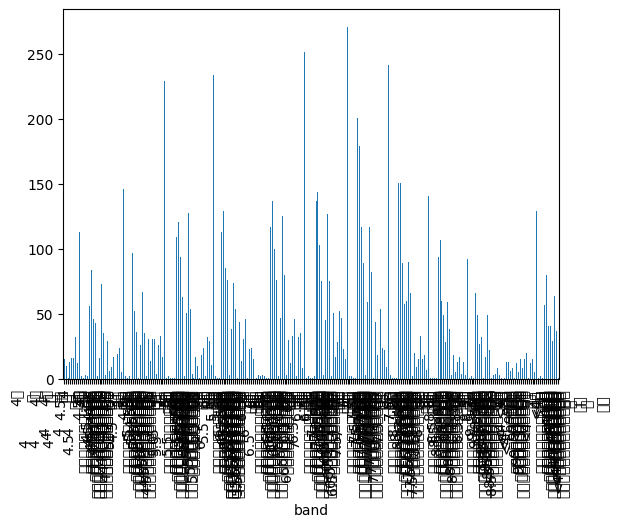

In [ ]:
raw_train_df['band'].value_counts().sort_index().plot(kind='bar')